In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import re

FILES

In [2]:
# high flow
file0 = '23-07-28_schlieren-08_postprocess-02_fluoro-3to3mm-573ccm-flow-989ccm-purge-flipped'
file1 = '23-07-26_schlieren-11_postprocess-02_fluoro-3to3mm-825ccm-flow-718ccm-purge-flipped'
file2 = '23-07-28_schlieren-10_postprocess-02_fluoro-3to3mm-959ccm-flow-550ccm-purge-flipped'

READ FILES

In [3]:
files = [file2, file1, file0] # initialise order
root = 'processed/'
ext = '.avi'
paths = [root+file+ext for file in files]

In [4]:
def get_flowrate(file):
    return re.findall('[0-9]*ccm', file)

flow_rates = [get_flowrate(file) for file in files] 
flow_rates

[['959ccm', '550ccm'], ['825ccm', '718ccm'], ['573ccm', '989ccm']]

In [5]:
flow_ints = [ int(flow[:-3]) for flow_rate in flow_rates for flow in flow_rate]
purge2flow = [round(flow_ints[ii+1]/flow_ints[ii],1) for ii in (0,2,4)]
data_labels = [[ratio]+flows for ratio, flows in zip(purge2flow, flow_rates)]
data_labels

[[0.6, '959ccm', '550ccm'],
 [0.9, '825ccm', '718ccm'],
 [1.7, '573ccm', '989ccm']]

SELECT FRAME

In [6]:
FPS = 24
def get_frames(capture, at_seconds):
    ii=1
    frames = []
    at_frames = np.rint(at_seconds*FPS)
    while True:
        rtn, frame = capture.read()
        if frame is None:
            break
        if ii in at_frames:
            frames.append(frame)
        ii+=1
    return frames

Selected frame for t=0 shortly after purge is turned on, then subsequent frames taken at t=3 and t=21

In [7]:
t0_file0 = 7.25 # seconds
t0_file1 = 12
t0_file2 = 5.1
t0 = [[t0_file2]*3, [t0_file1]*3, [t0_file0]*3] # initialise in same file order!!

at_seconds_each_file = np.array(t0) 
at_seconds_each_file[:,1]+=3 # seconds 
at_seconds_each_file[:,2]+=21 # seconds

captures = [cv.VideoCapture(path) for path in paths]
frames = [get_frames(capture, at_seconds) for capture, at_seconds in zip(captures, at_seconds_each_file)]

DISPLAY FRAME

In [8]:
font = { #'weight' : 'bold',
        'size'   : 14,
        'horizontalalignment': 'center',
        'verticalalignment' : 'bottom'
       }

def show_frame(frame): # return plt
    plt.figure(figsize=(8,8), edgecolor='black', linewidth = 1.5)
    plt.imshow(frame, cmap='gray', vmin=0, vmax=255) # on scale 0-255!
    plt.axis('off')
#     plt.text(750,1500,'1552 ccm', fontdict = font)
    return plt

def show_frames(frame1, frame2, frame3): # on scale 0-255! returns plt
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(frame1, cmap= 'gray', vmin=0, vmax=255)
    ax[1].imshow(frame2, cmap= 'gray', vmin=0, vmax=255)
    ax[2].imshow(frame3, cmap= 'gray', vmin=0, vmax=255)

    fig.set_size_inches(20,10)
    fig.patch.set_facecolor('white')
    plt.tight_layout(pad=2.5, w_pad=2.5, h_pad=5)
    return plt 

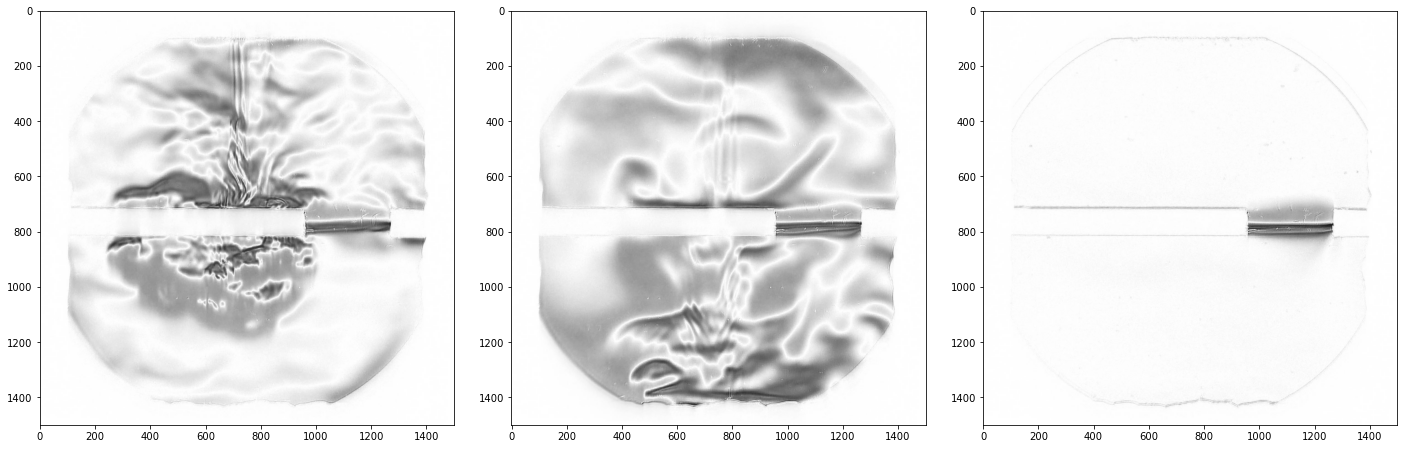

In [9]:
file = 2
row = frames[file]
show_frames(row[0], row[1], row[2]).show()

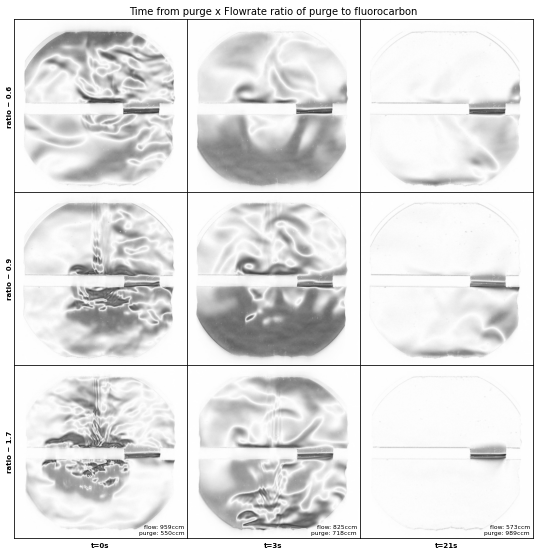

In [10]:
X_LABELS = ['t=0s','t=3s','t=21s']
TITLE = 'Time from purge x Flowrate ratio of purge to fluorocarbon'
def make_figure(frames_each_file, data_labels): # on scale 0-255! returns plt
    
    font_axes = { 
        'weight' : 'bold',
        'size'   : 7,
        'horizontalalignment': 'center',
        'verticalalignment' : 'bottom'
       }
    font_labels = { 
        'size'   : 6,
        'horizontalalignment': 'right',
        'verticalalignment' : 'bottom'
       }
    fig, axes = plt.subplots(3,3)
    fig.set_size_inches(7.9,8) # a4 fit
    label_coords = (1475, 1475)

    for jj, col in enumerate(frames):
        for ii, frame in enumerate(col):
#             axes[ii,jj].imshow(frame, cmap= 'gray', vmin=0, vmax=255)
            axes[jj,ii].imshow(frame, cmap= 'gray', vmin=0, vmax=255) 

            if jj==0:
                label = 'ratio ~ '+str(data_labels[ii][0])
                axes[ii,0].set_ylabel(label, fontdict = font_axes, labelpad=1) # purge:flow
            if ii==2:
                label = 'flow: '+data_labels[jj][1]+'\npurge: '+data_labels[jj][2]
                axes[2,jj].text(label_coords[0], label_coords[1], label, fontdict = font_labels) # flow rates
                axes[2,jj].set_xlabel(X_LABELS[jj], fontdict = font_axes, labelpad=10)

    for ax in axes.flat: # remove axes px values
        ax.set_xticks([])
        ax.set_yticks([])

    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    fig.patch.set_facecolor('white')
    
    subplotdim=3
    fig.set_size_inches(subplotdim*3,subplotdim*3) # a4 fit
    mid = (fig.subplotpars.right + fig.subplotpars.left)/2
    fig.suptitle(TITLE, fontsize=10, y =0.92)
    fig.subplots_adjust(top=0.9, left=0.1, right= 0.9, bottom = 0.1)
    return plt

make_figure(frames, data_labels).show()

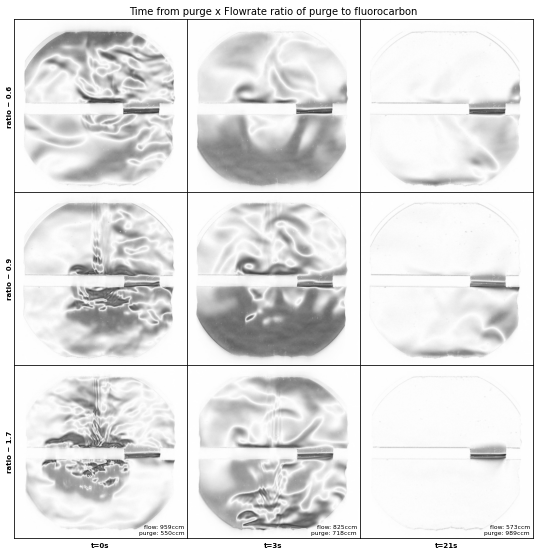

In [11]:
make_figure(frames, data_labels).savefig('fig3.png', dpi=900, bbox_inches = 'tight')